# Optimal Growth IV: The Endogenous Grid Method

## Overview

Previously, we solved the stochastic optimal growth model using

1. [value function iteration](https://python-programming.quantecon.org/optgrowth_fast.html)  
1. [Euler equation based time iteration](https://python-programming.quantecon.org/coleman_policy_iter.html)  


We found `time iteration` to be significantly more accurate and efficient.

In this lecture, we’ll look at a clever twist on time iteration called the **endogenous grid method** (EGM).

EGM is a numerical method for implementing policy iteration invented by [Chris Carroll](http://www.econ2.jhu.edu/people/ccarroll/).

Let’s start with some standard imports:

In [1]:
import numpy as np
import quantecon as qe
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
from quantecon.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

## Summary of Time Iteration Method


### Theory

Take the model set out in [the time iteration lecture](https://python-programming.quantecon.org/coleman_policy_iter.html), following the same terminology and notation.

The Euler equation from the time iteration lecture is

<a id='equation-egm-euler'></a>
$$
(u'\circ \sigma^*)(y)
= \beta \int (u'\circ \sigma^*)(f(y - \sigma^*(y)) z) f'(y - \sigma^*(y)) z \phi(dz) \tag{1}
$$

As we saw, the Coleman operator is a nonlinear operator $ K $ engineered so that $ \sigma^* $ is a fixed point of $ K $.

It takes as its argument a continuous strictly increasing consumption policy $ \sigma \in \Sigma $.

It returns a new function $ K \sigma $,  where $ (K \sigma)(y) $ is the $ c \in (0, \infty) $ that solves

<a id='equation-egm-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ \sigma) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{2}
$$

### Exogenous Grid

As discussed in [the lecture on time iteration](https://python-programming.quantecon.org/coleman_policy_iter.html), to implement the method on a computer, we need a numerical approximation.

In particular, we represent a policy function by a set of values on a finite grid.

The function itself is reconstructed from this representation when necessary, using interpolation or some other method.

Previously, to obtain a finite representation of an updated consumption policy, we

- fixed a grid of income points $ \{y_i\} $  
- calculated the consumption value $ c_i $ corresponding to each
  $ y_i $ using [(2)](#equation-egm-coledef) and a root-finding routine  

Each $ c_i $ is then interpreted as the value of the function $ K \sigma $ at $ y_i $.

Thus, with the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ K \sigma $ via approximation.

Iteration then continues…

## Key Idea of Endogenous Grid Method

The method discussed above requires a root-finding routine to find the $ c_i $ corresponding to a given income value $ y_i $.

Root-finding is costly because it typically involves a significant number of function evaluations.

As pointed out by Carroll (2006), we can avoid this if $ y_i $ is chosen endogenously.

The only assumption required is that $ u' $ is invertible on $ (0, \infty) $.

Let $ (u')^{-1} $ be the inverse function of $ u' $.

The idea is this:

- First, we fix an *exogenous* grid $ \{k_i\} $ for capital ($ k = y - c $).  
- Then we obtain  $ c_i $ via  


<a id='equation-egm-getc'></a>
$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ \sigma) (f(k_i) z ) \, f'(k_i) \, z \, \phi(dz)
\right\} \tag{3}
$$

- Finally, for each $ c_i $ we set $ y_i = c_i + k_i $.  


It is clear that each $ (y_i, c_i) $ pair constructed in this manner satisfies [(2)](#equation-egm-coledef).

With the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ K \sigma $ via approximation as before.

The name EGM comes from the fact that the grid $ \{y_i\} $ is  determined **endogenously**.

## Implementation

As before, we will start with a simple setting where

- $ u(c) = \ln c $,  
- production is Cobb-Douglas, and  
- the shocks are lognormal.  

This will allow us to make comparisons with the analytical (true) solutions

In [2]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

We construct the `OptimalGrowthModel` class which is almost identical to the one used in the time iteration lecture.

In [3]:
opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # Set up k-grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function"
        return k**self.α
       

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return 1/c

    def u_prime_inv(self, c):
        "Inverse of u'"
        return 1/c

### The Operator

Here’s an implementation of $ K $ using EGM as described above.

In [4]:
@njit
def K(σ_array, og):
    """
    The Coleman operator using EGM

    """

    # Simplify names
    f, β = og.f, og.β
    f_prime, u_prime = og.f_prime, og.u_prime
    u_prime_inv = og.u_prime_inv
    grid, shocks = og.grid, og.shocks

    # Determine endogenous grid
    y = grid + σ_array  # y_i = k_i + c_i

    # Linear interpolation of policy using endogenous grid
    σ = lambda x: interp(y, σ_array, x)

    # Allocate memory for new consumption array
    c = np.empty_like(grid)

    # Solve for updated consumption value
    for i, k in enumerate(grid):
        vals = u_prime(σ(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(β * np.mean(vals))

    return c

Note the lack of any root-finding algorithm.

### Testing

First we create an instance.

In [5]:
og = OptimalGrowthModel()
grid = og.grid

Here’s our solver routine:

In [6]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=5):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

Let’s call it:

In [7]:
%%time
σ_init = np.copy(grid)
σ = solve_model_time_iter(og, σ_init)

Error at iteration 5 is 0.05099394329535745.
Error at iteration 10 is 0.00043347299641194326.

Converged in 12 iterations.
Wall time: 1.15 s


Relative to time iteration, which as already found to be highly efficient, EGM has managed to shave off still more run time without compromising accuracy. This is due to the lack of a numerical root-finding step.

We can now solve the optimal growth model at given parameters extremely fast.

Here is a plot of the resulting policy, compared with the true policy:

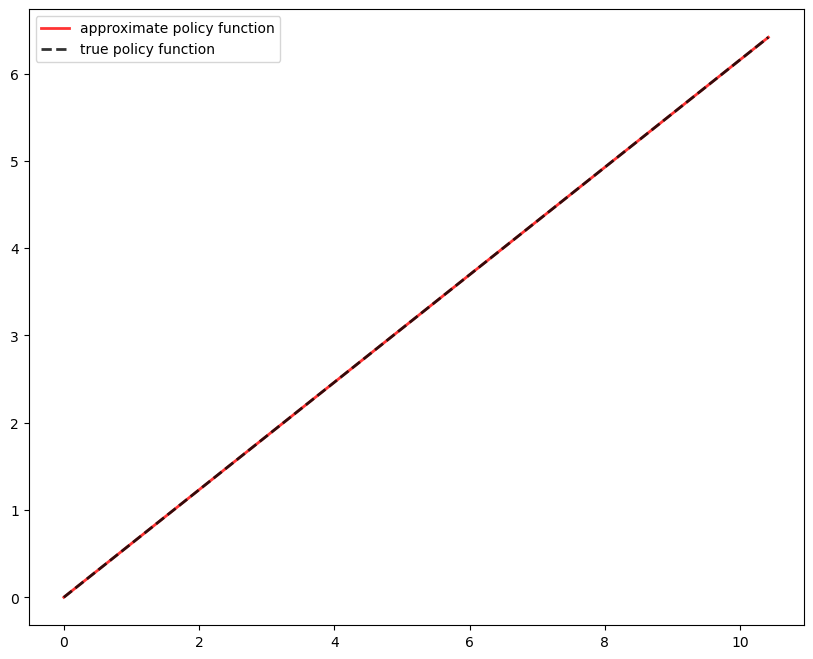

In [8]:
y = grid + σ  # y_i = k_i + c_i

fig, ax = plt.subplots()

ax.plot(y, σ, 'r-', lw=2, alpha=0.8, label='approximate policy function')
ax.plot(y, σ_star(y, og.α, og.β), 'k--', lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

The maximal absolute deviation between the two policies is

In [9]:
np.max(np.abs(σ - σ_star(y, og.α, og.β)))

1.530274914252061e-05